In [1]:
import os, sys

import torch
from torch import nn

from matplotlib import pyplot as plt
from tqdm import tqdm

from eot_benchmark.glow_model import Glow
from eot_benchmark.glow_train import calc_z_shapes
from eot_benchmark.auxiliary import get_data_home

from eot_benchmark.langevin_dynamics import (
    tensor_list_to_vector, vector_to_tensor_list,
    sample_z_list, z_list_to_image, metropolis_adjusted_latent_langevien_step,
    glow_log_p, log_p_x_y, log_f_x_y_image
)

from eot_benchmark.image_benchmark import ImageConditionalPlan

### Langevin config

In [2]:
EPS = 0.1
BATCH_SIZE = 16 # 40
LANGEVIEN_ITERATIONS = 200
DELTA_TIME = 1e-5
TEMP = 0.7 # samples from benchmark obtained with this temperature

### GLOW config

In [3]:
N_FLOW = 32
N_BLOCK = 4
AFFINE = False
NO_LU = False
IMG_SIZE = 64
N_SAMPLE = 40
GLOW_DEVICE = "cuda:0"
DEVICE_IDS = [0]

MODEL_SINGLE = Glow(
    3, N_FLOW, N_BLOCK, affine=AFFINE, conv_lu=not NO_LU
)
MODEL = nn.DataParallel(MODEL_SINGLE, device_ids=DEVICE_IDS)
MODEL = MODEL.to(GLOW_DEVICE)

# MODEL.load_state_dict(torch.load("../data/glow_model.pt"))
MODEL.load_state_dict(torch.load(os.path.join(get_data_home(),
                                              "image_benchmark/glow_model.pt"), map_location=GLOW_DEVICE))

SHAPES = calc_z_shapes(3, IMG_SIZE, N_FLOW, N_BLOCK)

/usr/local/lib/python3.8/dist-packages/eot_benchmark/glow_model.py:102: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  w_s = torch.from_numpy(w_s)


In [4]:
benchmark_data_path = os.path.join(get_data_home(), "image_benchmark")

potential_probs = torch.load(os.path.join(benchmark_data_path, "potentials", f"image_potential_probs_eps_{EPS}.torch"))
potential_mus = torch.load(os.path.join(benchmark_data_path, "potentials", f"image_potential_mus_eps_{EPS}.torch"))
potential_sigmas = torch.load(os.path.join(benchmark_data_path, "potentials", f"image_potential_sigmas_eps_{EPS}.torch"))

conditional_plan = ImageConditionalPlan(potential_probs, potential_mus, potential_sigmas, eps=EPS, device=GLOW_DEVICE)

### Langevin sampling

In [5]:
with torch.no_grad():
    z_list = sample_z_list(batch_size=1, z_shapes=SHAPES, device=GLOW_DEVICE)
    cond_img = z_list_to_image(MODEL, z_list)
    cond_img = conditional_plan.sample(cond_img)
    z_vector = tensor_list_to_vector(z_list)
    
initial_z = z_vector
z_vector = z_vector.repeat(BATCH_SIZE, 1)

for i in tqdm(range(LANGEVIEN_ITERATIONS)):
    log_f_x_y=lambda x,y: log_f_x_y_image(x, y, potential_probs=potential_probs,
                                          potential_mus=potential_mus,
                                          potential_sigmas=potential_sigmas, eps=EPS)
    log_p = lambda x: log_p_x_y(x, cond_img, MODEL,
                                temperature=TEMP, shapes=SHAPES, log_f_x_y=log_f_x_y)

    z_vector, is_accepted = metropolis_adjusted_latent_langevien_step(z_vector, log_p=log_p, delta_time=DELTA_TIME)

final_img = z_list_to_image(MODEL, vector_to_tensor_list(z_vector, SHAPES))

  0%|                                                                                                                                               | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/eot_benchmark/langevin_dynamics.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  current_y_probs = potential_probs*softmax(cat_distr.log_prob(y[0]))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:32<00:00,  1.06s/it]


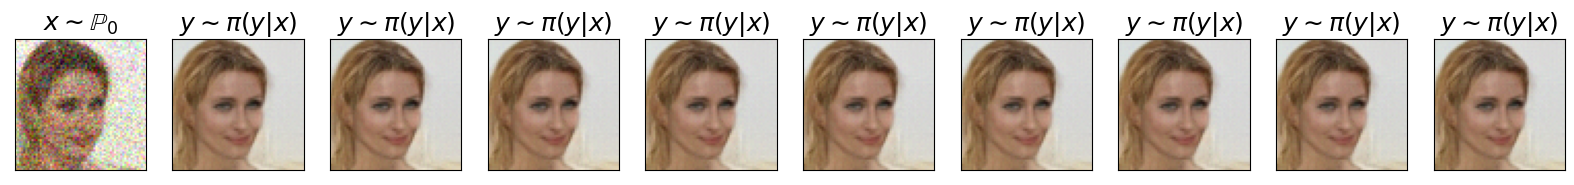

In [6]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))

for j in range(10):
    ax = axes[j]
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])
    
    if j == 0:
        ax.imshow((cond_img.cpu().permute(1, 2, 0)*0.5 + 0.5).clip(0, 1))
        ax.set_title(r"$x \sim \mathbb{P}_0$", fontsize=18)
    else:
        ax.imshow((final_img[j-1].cpu().permute(1, 2, 0)*0.5 + 0.5).clip(0, 1))
        ax.set_title(r"$y \sim \pi(y|x)$", fontsize=18)